# Notebook 3: Force inference

In this notebook, we will learn how to use [Foambryo](https://www.nature.com/articles/s41592-023-02084-7) for force inference from 3D images. 

## Load the data

We will load the sample data from the Foambryo paper. Launch the napari viewer and add the segmentation as a labels layer. Explore the data. How many cells are there? 

<img src="resources/foambryo_labels.png" alt="napari surface layer">

In [2]:
import napari
from skimage.io import imread

segmentation_path = "../data/part_3/Benchmark_labels.tif"
segmentation_image = imread(segmentation_path)

viewer = napari.Viewer()
viewer.add_labels(segmentation_image)

<Labels layer 'segmentation_image' at 0x10700cc10>

We will use the Foambryo meshing pipeline to create the mesh. Note how much smoother the surfaces are.

<img src="resources/foambryo_mesh.png" alt="napari surface layer">

In [11]:
from foambryo import dcel_mesh_from_segmentation_mask

# construct the mesh
dcel_mesh = dcel_mesh_from_segmentation_mask(
    segmentation_image,
    min_distance=3,
    print_info=True
)

# add the mesh to the viewer
vertices = dcel_mesh.v
faces = dcel_mesh.f[:, 0:3]
viewer.add_surface(
    (
        vertices, faces
    )
)


Computing EDT ...
EDT computed in  0.72
Searching local extremas ...
Number of local minimas : 6358
Number of local maxes : 153
Delaunay Tesselation built in 0.23 seconds
Graph build in  0.676
Watershed done in 0.2 seconds.


<Surface layer 'Surface' at 0x1785639d0>

## Infer forces

In [12]:
from foambryo import infer_forces

# infer both tensions and pressures
tensions, pressures = infer_forces(dcel_mesh)

The pressures are returned as a dictionary where the key is the label value of the cell and the value is the inferred pressure.

In [14]:
pressures

{0: 0,
 np.int64(1): np.float64(0.01774290505182492),
 np.int64(2): np.float64(0.03927119387118682),
 np.int64(3): np.float64(0.036905982054518296),
 np.int64(4): np.float64(0.04492606222374094),
 np.int64(5): np.float64(0.04404532322749534),
 np.int64(6): np.float64(0.033135580447285165)}

Recall that we are inferring one surface tension per interface. Each interface is either contacting two cells or one cell and background. The tensions are returned as a dictionary where the key are the label values for objects contacting the interface and the values are the inferred surface tensions. For example for the interface between cell 1 and background (label 0), the key would be `(0, 1)`.

In [20]:
# all surface tensions
tensions

{(np.int64(0), np.int64(1)): np.float64(0.47342023816346546),
 (np.int64(0), np.int64(2)): np.float64(0.8753760645515956),
 (np.int64(0), np.int64(3)): np.float64(0.8670277722957505),
 (np.int64(0), np.int64(4)): np.float64(1.0036769829654764),
 (np.int64(0), np.int64(5)): np.float64(0.9725211571313337),
 (np.int64(0), np.int64(6)): np.float64(0.8276201845764745),
 (np.int64(1), np.int64(2)): np.float64(0.6857833446078454),
 (np.int64(1), np.int64(3)): np.float64(0.8613498249437229),
 (np.int64(1), np.int64(4)): np.float64(1.0022423429072338),
 (np.int64(1), np.int64(5)): np.float64(1.0469225590458409),
 (np.int64(1), np.int64(6)): np.float64(0.8058025358044711),
 (np.int64(2), np.int64(3)): np.float64(1.0464774350284418),
 (np.int64(2), np.int64(4)): np.float64(1.4698428080484245),
 (np.int64(2), np.int64(6)): np.float64(1.138141853466497),
 (np.int64(3), np.int64(6)): np.float64(0.5625781065629598),
 (np.int64(4), np.int64(5)): np.float64(1.700868263822727),
 (np.int64(4), np.int64(6

In [19]:
# only surface tensions from interface between background and cell 1
tensions[(0, 1)]

np.float64(0.47342023816346546)

## Compare surface tensions

First we will compare the surface tensions across different types of interfaces. Make a histogram comparing the surface tension for interfaces that are touching the media/background (i.e., label value 0) and other cells (i.e., non-zero labels)

Text(0.5, 0, 'Surface tension')

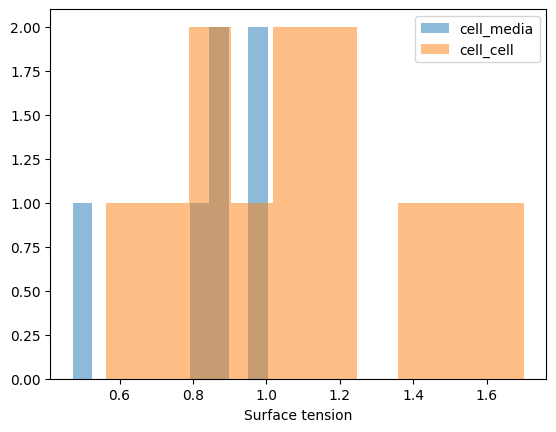

In [29]:
from matplotlib import pyplot as plt



Recall that the surface tensions are relative and to compare our inferred properties across samples, we should compare rations. Next, for each cell, take the ratio of it's cell-media surface tension to it's cell-cell surface tensions. This is approximately what is known as the compaction parameter and is known to be a mechanical driver of compaction in early mamallian embryogenesis ([Firmin et al., 2024](https://www.nature.com/articles/s41586-024-07351-x)). Plot a histogram of this ratio.

(array([1., 0., 1., 0., 1., 2., 0., 0., 0., 1.]),
 array([0.53772083, 0.58923848, 0.64075614, 0.69227379, 0.74379145,
        0.7953091 , 0.84682675, 0.89834441, 0.94986206, 1.00137972,
        1.05289737]),
 <BarContainer object of 10 artists>)

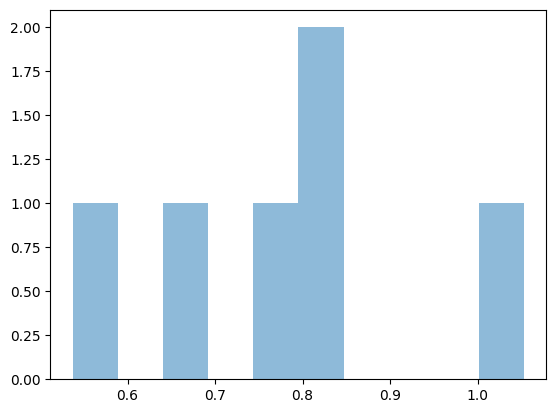

In [36]:
import numpy as np
